### Creating and publishing a hugging face dataset with references to anndata files. 

Can for example be used to train multimodal models with mmcontext. The datasets consist of a reference to a sample of an anndata file,
which can be stored locally or remotly on nextcloud. 

Use the initial embedder to include some initial embeddings into our anndata object which can then be used later.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from adata_hf_datasets.utils import setup_logging

setup_logging()

<RootLogger root (INFO)>

In [29]:
import anndata

data_name = "cellxgene_pseudo_bulk"
adata = anndata.read_h5ad(f"../data/RNA/raw/{data_name}.h5ad")

In [30]:
adata

AnnData object with n_obs × n_vars = 376983 × 38030
    obs: 'age', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'cluster_name', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'is_primary_data', 'lobe', 'organism', 'organism_ontology_term_id', 'orig.ident', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'based_on_n_cells', 'abstract', 'dataset_title', 'Sort_id', 'celltype_annotation', 'is_maternal_contaminant', 'original_pub', 'predicted_doublets', 'sample', 'sample_long', 'scvi_clusters', 'Age', 'Amyloid', 'Braak', 'Cell.Types', 'PMI', 'RIN', 'SORT', 'Sample.ID', 'dissection', 'roi', 'sample_id', 'supercluster_term', 'batch', 'cell_cycle', 'cell_description', 'BMI', 'cds', 'donor_region', 'group', 'hash_cluster', 'hash_label', 'hashed', 'lineage', 'pct_counts_hb', 'phase', 'treatment', 'type',

In [22]:
# subset 10k random cells
import numpy as np

np.random.seed(42)
adata = adata[np.random.choice(adata.obs_names, 10000, replace=False)]

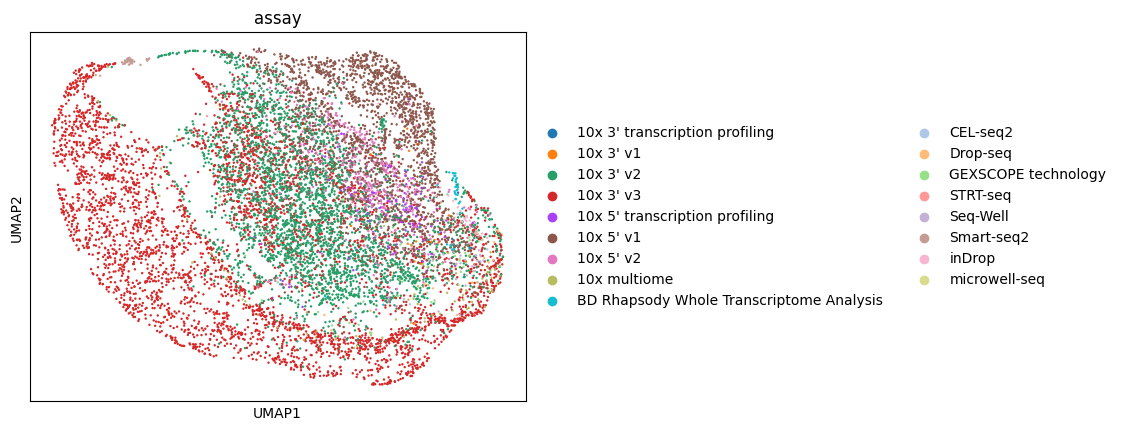

In [28]:
import scanpy as sc

sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="assay")

In [5]:
adata.obs["natural_language_annotation"]
caption_key = "natural_language_annotation"

In [6]:
# Delete objects that are not needed and are taking up space
del adata.obsm["natural_language_annotation_replicates"]
del adata.layers

In [7]:
from adata_hf_datasets.initial_embedder import InitialEmbedder

method = "pca"
dataset_name = f"{data_name}_{method}"

embedder = InitialEmbedder(method=method)
embedder.fit(adata)
embedder.embed(adata)

2025-02-07 14:48:30,720 - adata_hf_datasets.initial_embedder - INFO - Fitting method 'pca' with embedding_dim=64


2025-02-07 14:48:30,721 - adata_hf_datasets.initial_embedder - INFO - Fitting PCA with 64 components.


KeyboardInterrupt: 

In [32]:
from adata_hf_datasets.utils import split_anndata
import os
from pathlib import Path

project_dir = Path().resolve().parents[0]
train_path = f"{project_dir}/data/RNA/processed/{method}/{data_name}/train.h5ad"
val_path = f"{project_dir}/data/RNA/processed/{method}/{data_name}/val.h5ad"
os.makedirs(os.path.dirname(train_path), exist_ok=True)
os.makedirs(os.path.dirname(val_path), exist_ok=True)
train_data, val_adata = split_anndata(adata, train_size=0.9)
train_data.write(train_path)
val_adata.write(val_path)

In [33]:
train_remote_path = f"datasets/{method}/train/bowel_disease.h5ad"
val_remote_path = f"datasets/{method}/val/bowel_disease.h5ad"

In [34]:
from dotenv import load_dotenv

load_dotenv(override=True)
nextcloud_config = {
    "url": "https://nxc-fredato.imbi.uni-freiburg.de",
    "username": "NEXTCLOUD_USER",  # env will we obtained within code
    "password": "NEXTCLOUD_PASSWORD",
    "remote_path": "",
}

In [35]:
from adata_hf_datasets.adata_ref_ds import AnnDataSetConstructor
from adata_hf_datasets.adata_ref_ds import SimpleCaptionConstructor
from datasets import DatasetDict

hf_dataset = DatasetDict()
# Create caption constructor with desired obs keys
for split, path in zip(["train", "val"], [train_path, val_path]):
    caption_constructor = SimpleCaptionConstructor(obs_keys=caption_key)
    nextcloud_config["remote_path"] = eval(f"{split}_remote_path")
    constructor = AnnDataSetConstructor(
        caption_constructor=caption_constructor,
        store_nextcloud=True,
        nextcloud_config=nextcloud_config,
    )
    constructor.add_anndata(file_path=path)
    # Get dataset
    dataset = constructor.get_dataset()
    hf_dataset[split] = dataset

2025-02-07 14:36:00,605 - datasets - INFO - PyTorch version 2.6.0 available.
2025-02-07 14:38:57,374 - root - INFO - File saved locally at /Users/mengerj/repos/adata_hf_datasets/data/scRNA/processed/pca/cellxgene_pseudo_bulk/train.h5ad


Directory already exists: datasets
Directory already exists: pca
Directory already exists: train


In [69]:
from adata_hf_datasets.utils import annotate_and_push_dataset

caption_generation = f"""Captions were generated with the SimpleCaptionConstructor class. That means the previosly added annotation from the
                following obs_keys were concatenated: {caption_constructor.obs_keys}."""

embedding_generation = f"""Embeddings were generated with the InitialEmbedder class from the adata_hf_datasets package, with method = {method}, they have 
        {embedder.embedding_dim} dimensions, and are stored in adata.obsm['X_{method}']"""

annotate_and_push_dataset(
    dataset=hf_dataset,
    caption_generation=caption_generation,
    embedding_generation=embedding_generation,
    repo_id=f"jo-mengr/{dataset_name}",
    readme_template_name="cellxgene_pseudo_bulk",
)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/21 [00:00<?, ?ba/s]

In [70]:
from datasets import load_dataset

dataset_loaded = load_dataset(f"jo-mengr/{dataset_name}")

train-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/233k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [59]:
dataset_loaded

DatasetDict({
    train: Dataset({
        features: ['anndata_ref', 'caption', 'label'],
        num_rows: 20114
    })
    test: Dataset({
        features: ['anndata_ref', 'caption', 'label'],
        num_rows: 20114
    })
})